In [1]:
import numpy as np
import pandas as pd
import _pickle as cPickle
import matplotlib.pyplot as plt

# 2. Feature engineering.

More about feature analysis since most of the columns are dropped.

### 2.1. Load the already converted data. Divide all the users into fraud and clear. Check an amount of transactions for users from both groups.

In [2]:
with open('transactions_train_valid_test_splits_postprocessed.pickle', 'rb') as f:
    data = cPickle.load(f)
train_data = data['train']
del data

In [3]:
train_data_clear_users = train_data[train_data['IsFraud_target'] == 0]
train_data_fraud_users = train_data[train_data['IsFraud_target'] == 1]

train_clear_grouped = train_data_clear_users.groupby('User')
train_fraud_grouped = train_data_fraud_users.groupby('User')

train_data_clear_users_total_trans = train_clear_grouped.count()['Amount'].values
train_data_fraud_users_total_trans = train_fraud_grouped.count()['Amount'].values

16 82355
783 65336


<Figure size 432x288 with 0 Axes>

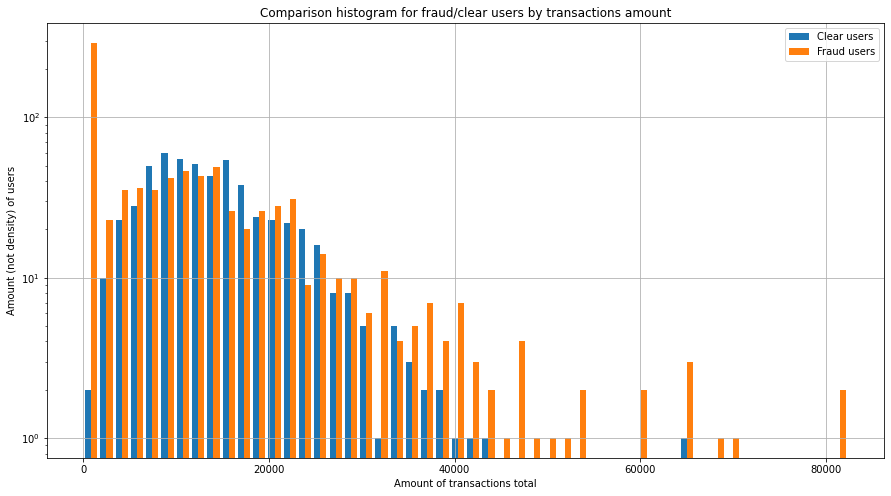

In [4]:
print(train_data_clear_users_total_trans.min(), train_data_clear_users_total_trans.max())
print(train_data_fraud_users_total_trans.min(), train_data_fraud_users_total_trans.max())

# First find bins, then draw for both datasets
n_bins = 50
_, bins, _ = plt.hist(train_data_clear_users_total_trans, bins=n_bins)
plt.clf()
fig = plt.figure(figsize=(15, 8))

plt.hist([train_data_fraud_users_total_trans, train_data_clear_users_total_trans],
         label=['Clear users', 'Fraud users'], rwidth=0.8, bins=bins)

plt.title('Comparison histogram for fraud/clear users by transactions amount')
plt.grid(True)
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel('Amount of transactions total')
plt.ylabel('Amount (not density) of users')
plt.show()


### 2.2. Check the distribution of clear and fraud users (clear - 843, fraud - 557).

Taking an imbalance into account tells about the requirement to sample it in equal proportion during training, use a balanced accuracy and monitor both precision and recall for all the datasets.

In [5]:
fraud = train_data_fraud_users['User'].unique()
clear = train_data_clear_users['User'].unique()
print('Clear', len(clear), 'fraud', len(fraud))
print('Intersection', len(set(fraud) & set(clear)))

Clear 843 fraud 557
Intersection 0


### 2.3. Try to analyse the difference in expenses.

<Figure size 432x288 with 0 Axes>

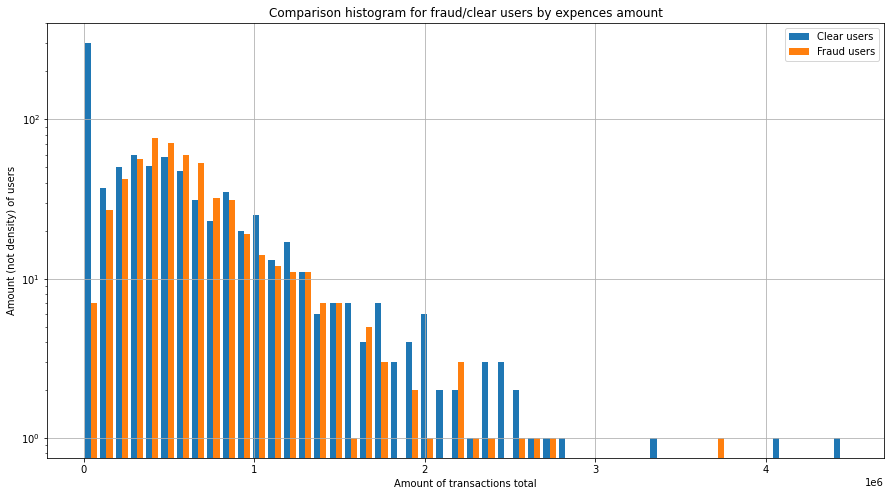

In [6]:
train_clear_users_total_money_spent = train_clear_grouped.sum()['Amount']
train_fraud_users_total_money_spent = train_fraud_grouped.sum()['Amount']

# First find bins, then draw for both datasets
n_bins = 50
_, bins, _ = plt.hist(train_clear_users_total_money_spent, bins=n_bins)
plt.clf()
fig = plt.figure(figsize=(15, 8))

plt.hist([train_clear_users_total_money_spent, train_fraud_users_total_money_spent],
         label=['Clear users', 'Fraud users'], rwidth=0.8, bins=bins)

plt.title('Comparison histogram for fraud/clear users by expences amount')
plt.grid(True)
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel('Amount of transactions total')
plt.ylabel('Amount (not density) of users')
plt.show()

### 2.3. Check a distribution of different prices.

There seems no obvious feature which relies on the distribution of prices of goods spent by a user.
Fraud users` expenses distribution are often bi-modal but there are clear users who also have bi-modal distribution of expenses.

In [7]:
print(train_data['Amount'].describe())
a_min = train_data['Amount'].min()
a_max = train_data['Amount'].max()

bins = np.linspace(a_min, a_max, num=100)
# Min and max values for a value corresponding to a bin
y_min = 1
y_max = 10000

count    1.739722e+07
mean     4.344026e+01
std      8.184734e+01
min     -5.000000e+02
25%      9.340000e+00
50%      3.039000e+01
75%      6.445000e+01
max      1.239050e+04
Name: Amount, dtype: float64


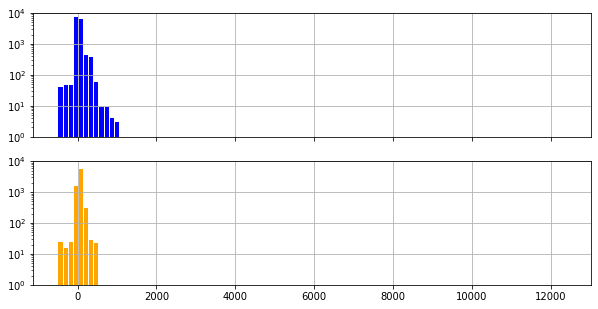

In [8]:
# Select random clear and fraud users, compare their
i = np.random.choice(clear)
j = np.random.choice(fraud)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
ax[0].hist(train_clear_grouped.get_group(i)['Amount'],
           label='Clear', bins=bins, rwidth=0.8, color='blue')
ax[0].set_yscale('log')
ax[0].grid(True)
ax[0].set_ylim(y_min, y_max)
ax[1].hist(train_fraud_grouped.get_group(j)['Amount'],
           label='Fraud', bins=bins, rwidth=0.8, color='orange')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].set_ylim(y_min, y_max)
plt.show()

### 2.4. Check the money flow during time for two groups of users.

Fraud user may perform some fraud transactions in group or gradually increase the prices trying to hide real intentions.

Plots show that
- Some fraudsters start with very intensive buyings and slow down then, e.g. (i, j) = (1987, 1132)
- There are a lot of silly fraudsters since they do not try to hide and their transactions totally differ from the nearest transactions in time

In [23]:
# Overview column properties
train_data['Datetime'].describe()

/tmp/ipykernel_13787/588384471.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_data['Datetime'].describe()


count                17397216
unique                7001898
top       2020-01-10 08:11:00
freq                       18
first     1991-01-02 07:10:00
last      2020-02-28 23:58:00
Name: Datetime, dtype: object

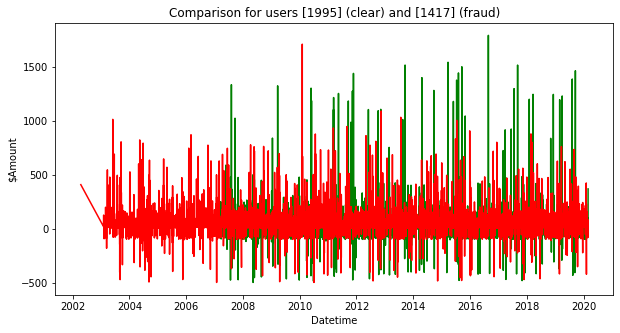

In [71]:
i = np.random.choice(clear)
j = np.random.choice(fraud)

a = train_clear_grouped.get_group(i)[['Amount', 'Datetime']].sort_values('Datetime')
b = train_fraud_grouped.get_group(j)[['Amount', 'Datetime']].sort_values('Datetime')

plt.figure(figsize=(10, 5))
plt.title(f'Comparison for users [{i}] (clear) and [{j}] (fraud)')
plt.plot(a['Datetime'].values, a['Amount'].values, '-g', label='Clear user')
plt.plot(b['Datetime'].values, b['Amount'].values, '-r', label='Fraud user')
plt.xlabel('Datetime')
plt.ylabel('$Amount')
plt.show()

### 2.5. Find the max sequence length for all users. Sequence is ordered from now.

More required on the next steps.

In [ ]:
len_max_clear = train_data_clear_users_total_trans.max()
len_max_fraud = train_data_fraud_users_total_trans.max()
len_max_all = max(len_max_clear, len_max_fraud)

In [ ]:
exit()
